In [ ]:
#Author: Lori Garzio
#Plot hourly energy demand (downloaded from https://dataminer2.pjm.com/feed/hrl_load_metered) vs windspeed and estimated
#wind power at 160m at the "Endurance" point in the middle of the WEA off of Atlantic City, NJ.

#modification instead of the endurance point, different lease areas will be used




#objective is to plot sea bree

In [5]:
import datetime as dt
import os
import xarray as xr
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import functions.common as cf
from functions.common import return_seabreeze_datetimes
pd.set_option('display.width', 320, "display.max_columns", 15)  # for display in pycharm console
plt.rcParams.update({'font.size': 12})  # all font sizes are 12 unless otherwise specified

In [6]:
#arguments

#point = [39.17745, -74.18033]
lease_site = "OCS-A0498"
start_date = dt.datetime(2022, 6, 1, 0, 0)  
end_date = dt.datetime(2022, 8, 31, 23, 0)

# grab the location of the specified site
point_location = '/Users/jameskim/Documents/rucool/Repositories/wind-science/files/virtual_met_towers.csv'

df_location = pd.read_csv(point_location, skipinitialspace=True)
site = df_location.loc[df_location['name'] == lease_site]
site_lat = site.latitude.values[0]
site_lon = site.longitude.values[0]

point = [site_lat, site_lon]


In [7]:
#Gab WRF data
wrf = 'http://tds.marine.rutgers.edu/thredds/dodsC/cool/ruwrf/wrf_4_1_3km_processed/WRF_4.1_3km_Processed_Dataset_Best'
plt_vars = ['windspeed', 'power']


# enter start and end date (arguments)
ds = xr.open_dataset(wrf)
ds = ds.sel(time=slice(start_date, end_date))

 # calculate the sum of the absolute value distance between the model location and buoy location
a = abs(ds['XLAT'] - point[0]) + abs(ds['XLONG'] - point[1])

# find the indices of the minimum value in the array calculated above
i, j = np.unravel_index(a.argmin(), a.shape)

# get u and v component, calculate windspeed and estimated wind power
u = ds.sel(height=160)['U'][:, i, j]
v = ds.sel(height=160)['V'][:, i, j]
ws = cf.wind_uv_to_spd(u,v)

ws_df = ws.to_dataframe('windspeed')

In [8]:
# Calculating Power

power_curve =pd.read_csv('/Users/jameskim/Documents/rucool/Repositories/wind-science/files/wrf_lw15mw_power.csv')


# estimated 15MW wind power (kW)
power = xr.DataArray(np.interp(ws, power_curve['Wind Speed'], power_curve['Power']), coords=ws.coords)
power_df = power.to_dataframe('power')
power_df['power'] = power_df['power'] * .001  # convert kw to mw

In [9]:
# READ CSV SEABREEZE FUNCTION
csv_file = '/Users/jameskim/Documents/rucool/Repositories/wind-science/files/BPU_Seabreeze.csv'

df_sea = pd.read_csv(csv_file)

# get seabreeze datetimes
df_sb = df_sea[df_sea['sea_breeze'] == 'Y']
sb_dates = np.array(pd.to_datetime(df_sb['date']))
sb_datetimes = [pd.date_range(pd.to_datetime(x), pd.to_datetime(x) + dt.timedelta(hours=23), freq='H') for x in           #changes the sea breeze "days" into and hourly data set
                sb_dates]
sb_datetimes = pd.to_datetime(sorted([inner for outer in sb_datetimes for inner in outer])) #chnages back into a datime index to work with other data sets
sb_datetimes_df = pd.DataFrame(sb_datetimes, columns=['time']) # creates a column
sb_datetimes_df['seabreeze'] = 'y'  # adds another coulnm titles seabreeze "y"
sb_datetimes_df.set_index('time', inplace=True)


# get non-seabreeze datetimes
df_nosb = df_sea[df_sea['sea_breeze'] == 'N']
nosb_dates = np.array(pd.to_datetime(df_nosb['date']))
nosb_datetimes = [pd.date_range(pd.to_datetime(x), pd.to_datetime(x) + dt.timedelta(hours=23), freq='H') for x
                    in nosb_dates]
nosb_datetimes = pd.to_datetime(sorted([inner for outer in nosb_datetimes for inner in outer]))
nosb_datetimes_df = pd.DataFrame(nosb_datetimes, columns=['time'])
nosb_datetimes_df['seabreeze'] = 'n'
nosb_datetimes_df.set_index('time', inplace=True)


In [10]:
seabreeze_dataframe = sb_datetimes_df.append(nosb_datetimes_df)
seabreeze_dataframe.sort_index(inplace=True)

In [17]:
# read in PJM data
pjm_dir ='/Users/jameskim/Documents/rucool/Repositories/wind-science/files/PJM_energy_load_AE'

csv_files = glob.glob(os.path.join(pjm_dir, '*.csv'))  # '*_AE.csv'
df_pjm = pd.DataFrame()
for csv_file in csv_files:
    df1 = pd.read_csv(csv_file)
    df_pjm = df_pjm.append(df1)  # append to the main dataframe


In [18]:
# get the total hourly demand
df_pjm['time'] = pd.to_datetime(df_pjm['datetime_beginning_utc']) #rename the column to 'time' and convert to datetime
df_pjm.set_index('time', inplace=True)
df_total = df_pjm.groupby('time').sum() #creates gruops for each unique time value

merged1 = df_total.merge(power_df, on='time', how='outer')
merged2 = merged1.merge(ws_df, on='time', how='outer')
merged = merged2.merge(seabreeze_dataframe, on='time', how='outer')
merged.dropna(inplace=True)

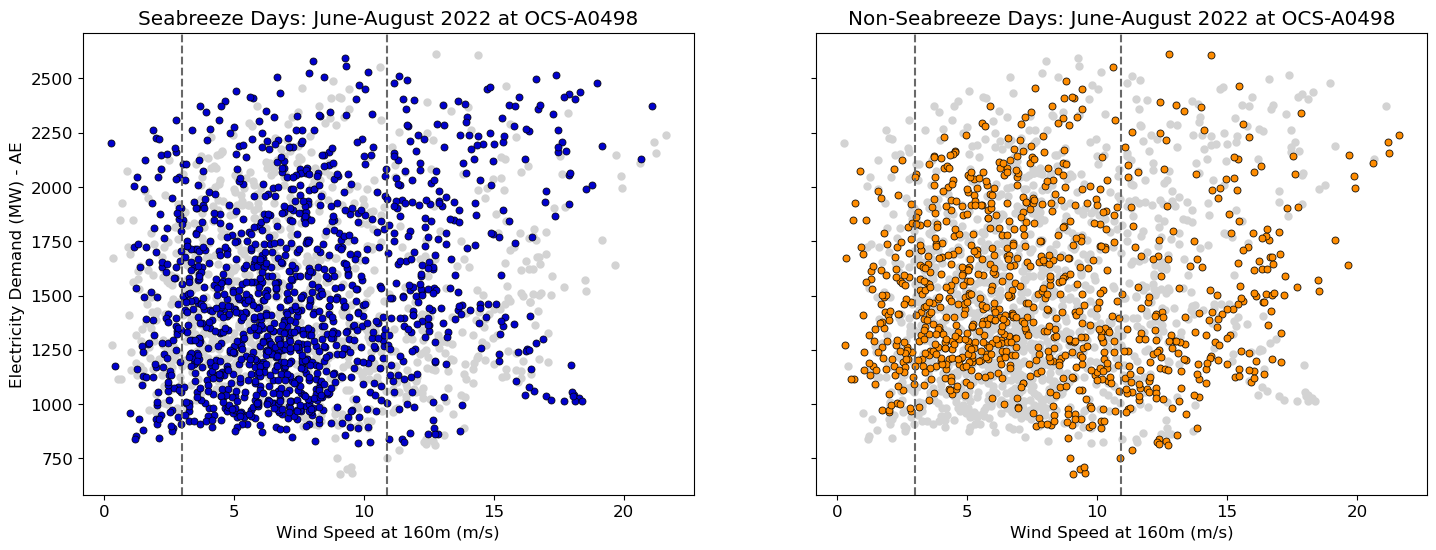

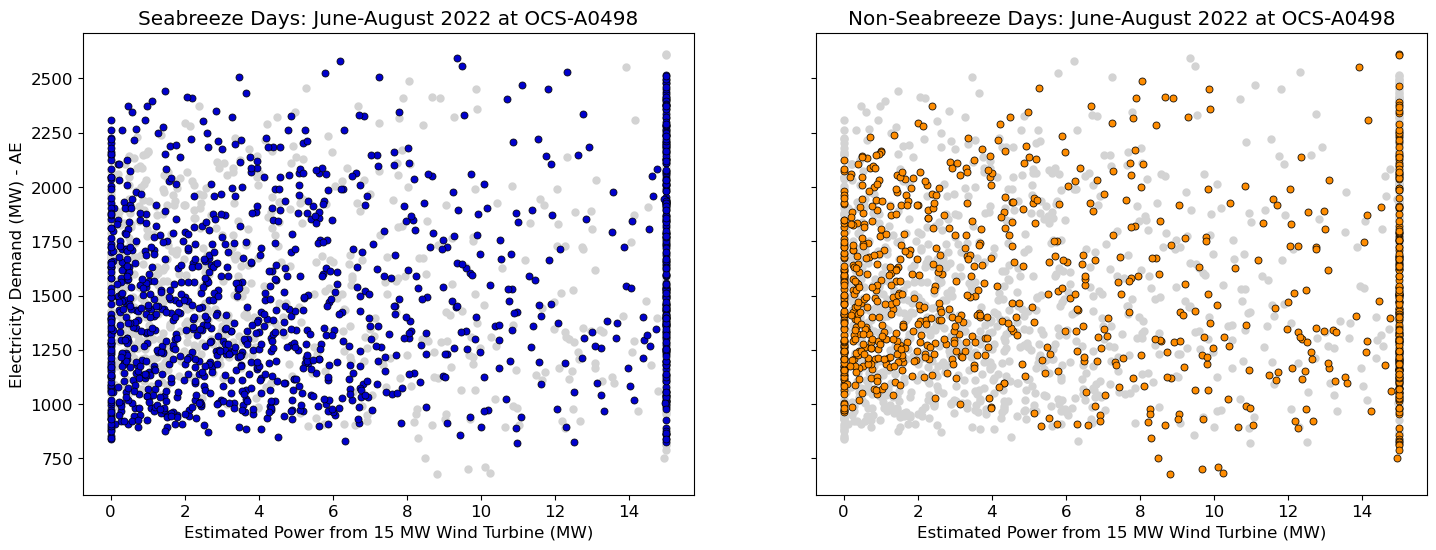

In [20]:
#plotting 
for pv in plt_vars:
        #savedir = os.path.join(sDir, f'demand_vs_{pv}')
        #os.makedirs(savedir, exist_ok=True)

        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 6), sharex=True, sharey=True)
        plt.subplots_adjust(left=0.08, right=0.92)

        sb = merged[merged['seabreeze'] == 'y']
        nosb = merged[merged['seabreeze'] == 'n']

        ax1.scatter(merged[pv], merged.mw, color='lightgray', s=25)
        ax2.scatter(merged[pv], merged.mw, color='lightgray', s=25)

        ax1.scatter(sb[pv], sb.mw, color='mediumblue', edgecolor='k', s=25, linewidth=.5)
        ax2.scatter(nosb[pv], nosb.mw, color='darkorange', edgecolor='k', s=25, linewidth=.5)

        ax1.set_title(f'Seabreeze Days: June-August 2022 at {lease_site}')
        ax2.set_title(f'Non-Seabreeze Days: June-August 2022 at {lease_site}')

        ax1.set_ylabel('Electricity Demand (MW) - AE')
        if pv == 'power':
            xaxis = 'Estimated Power from 15 MW Wind Turbine (MW)'
        elif pv == 'windspeed':
            xaxis = 'Wind Speed at 160m (m/s)'
            xposition = [3, 10.9]
            for xc in xposition:
                ax1.axvline(x=xc, color='dimgray', linestyle='--')
                ax2.axvline(x=xc, color='dimgray', linestyle='--')
        ax1.set_xlabel(xaxis)
        ax2.set_xlabel(xaxis)

        plt.show

        #save_filename = 'demand_vs_{}_seabreeze_{}-{}.png'.format(pv, sdate.strftime('%Y%m%d'), edate.strftime('%Y%m%d'))  # -AE
        #sfile = os.path.join(savedir, save_filename)
        #plt.savefig(sfile, dpi=300)
        #plt.close()
